In [1]:
import numpy as np
import gymnasium
from gymnasium.wrappers import TimeLimit
from imitation.data import rollout
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.policies import ActorCriticCnnPolicy

from gymnasium.spaces import Box
from gymnasium.envs.registration import register
import racing_gym
import os
import json
from PIL import Image
import torch
import time


/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
from PIL import Image

def load_expert_data_directory(parent_directory):
    # parent_directory内のすべてのディレクトリを取得
    subdirectories = [os.path.join(parent_directory, d) for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    
    all_expert_data = []  # すべてのディレクトリのexpert_dataを格納するリスト

    for data_path in subdirectories:
        # ディレクトリごとにexpert_dataの初期化
        expert_data = {'images': [], 'actions': []}

        # 画像ファイルに対応するJSONファイルを取得
        json_file_list = [json_file for json_file in os.listdir(data_path) if json_file.startswith('record_') and json_file.endswith('.json')]

        for json_file in json_file_list:
            # レコードのファイルパスを構築
            json_path = os.path.join(data_path, json_file)

            # レコードの読み込み
            try:
                with open(json_path, 'r') as json_file:
                    record_data = json.load(json_file)
            except FileNotFoundError:
                print(f"エラー：{json_path} でJSONファイルが見つかりませんでした。")
                continue
            except json.JSONDecodeError:
                print(f"エラー：{json_path} のJSONファイルのデコードに失敗しました。")
                continue

            # 画像データの読み込み
            image_file = record_data.get('cam/image_array', '')  # 画像ファイル名をJSONから取得
            image_path = os.path.join(data_path, image_file)
            try:
                image_data = np.array(Image.open(image_path))
            except FileNotFoundError:
                print(f"エラー：{image_path} で画像ファイルが見つかりませんでした。")
                continue

            # expert_dataに追加
            expert_data['images'].append(image_data)
            expert_data['actions'].append([record_data.get('user/angle', 0), record_data.get('user/throttle', 0)])
        
        # すべてのディレクトリのexpert_dataをリストに追加
        all_expert_data.append(expert_data)


    return all_expert_data


In [36]:
all_expert_data = load_expert_data_directory('../../autorace/data/S1/')

In [56]:

print(all_expert_data[0].keys())
x, y, z = all_expert_data[0]['images'][0].shape
print(x)
print(len(all_expert_data[0]['images']))

print(transitions.obs.shape)
print(transitions.dones.shape)


dict_keys(['images', 'actions'])
224
793
(49621, 3, 224, 224)
(49621,)


In [62]:
from imitation.data.types import Transitions

def convert_to_transitions(expert_data):
    obs_array = []
    next_obs_array = []
    action_array = []
    done_array = []
    info_array = []
    # expert_dataの画像と行動をTrajectoryに変換
    for data in expert_data:
        data_size = len(data['images'])
        obs_array+=data['images']
        n_obs = data['images'].copy()
        n_obs.pop(0)
        x, y, z = data['images'][-1].shape
        n_obs.append(np.zeros((x, y, z), dtype=np.uint8))
        next_obs_array+=(n_obs)
        action_array+=data['actions']
        done_array+=[False]*(data_size-1)+[True]
        info_array+=[{}]*data_size
    transitions=Transitions( 
        obs=np.array(obs_array),
        acts=np.array(action_array),
        next_obs=np.array(next_obs_array),
        dones=np.array(done_array),
        infos=np.array(info_array))


    return transitions

In [63]:
test_trajectory = convert_to_transitions(all_expert_data)
print(test_trajectory)

Transitions(obs=array([[[[158, 103,  73],
         [155, 100,  70],
         [154,  99,  69],
         ...,
         [143, 141, 154],
         [137, 135, 148],
         [128, 126, 139]],

        [[156, 101,  71],
         [156, 101,  71],
         [156, 101,  71],
         ...,
         [139, 137, 150],
         [135, 133, 146],
         [127, 125, 138]],

        [[154,  99,  69],
         [156, 101,  71],
         [158, 103,  73],
         ...,
         [136, 134, 147],
         [133, 131, 144],
         [127, 125, 138]],

        ...,

        [[106,  55,  34],
         [109,  58,  37],
         [112,  61,  40],
         ...,
         [113, 116, 135],
         [112, 115, 134],
         [112, 115, 134]],

        [[108,  57,  36],
         [111,  60,  39],
         [113,  62,  41],
         ...,
         [113, 116, 135],
         [112, 115, 134],
         [114, 117, 136]],

        [[111,  60,  39],
         [113,  62,  41],
         [115,  64,  43],
         ...,
         [113, 116

In [4]:
reshaped_all_expert_data = all_expert_data.copy()
# すべてのディレクトリに対して
for i in range(len(reshaped_all_expert_data)):
    # すべての画像を変換
    for j in range(len(reshaped_all_expert_data[i]['images'])):
        # 画像の軸の順序を変更
        reshaped_image = np.transpose(reshaped_all_expert_data[i]['images'][j], (2, 0, 1))
        
        # expert_dataに変更を反映
        reshaped_all_expert_data[i]['images'][j] = reshaped_image.copy()

# 形状を確認
print(reshaped_all_expert_data[0]['images'][0].shape)

for i in range(len(reshaped_all_expert_data)):
    for j in range(len(reshaped_all_expert_data[i]['images'])):
        if reshaped_all_expert_data[i]['images'][j].shape != (3, 224, 224):
            print(i, j)

(3, 224, 224)


In [5]:
env_id1 = 'RacingEnv-v1'  # あなたの環境の名前に変更してください
try:
    env1 = gymnasium.make(env_id1, expert_data=reshaped_all_expert_data)
    print(f"Environment '{env_id1}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

1
Environment 'RacingEnv-v1' is successfully registered.


/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v1 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


In [6]:
def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env1 = gymnasium.make("RacingEnv-v1", expert_data=reshaped_all_expert_data)
    _env1 = RolloutInfoWrapper(_env1)
    return _env1

venv1 = DummyVecEnv([_make_env for _ in range(4)])

1
9
12
13


In [7]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common.evaluation import evaluate_policy


expert = PPO(
    policy=CnnPolicy,
    env=env1,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
    device='cuda:1'
)
reward, _ = evaluate_policy(expert, env1, 10)
print(f"Reward before training: {reward}")


# Note: if you followed step 2a, i.e. registered the environment, you can use the environment name directly

# expert = PPO(
#     policy=MlpPolicy,
#     env="custom/ObservationMatching-v0",
#     seed=0,
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0003,
#     n_epochs=10,
#     n_steps=64,
# )
expert.learn(100000)  # Note: set to 100000 to train a proficient expert
reward, _ = evaluate_policy(expert, expert.get_env(), 10)
print(f"Expert reward: {reward}")

/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


12
15
21
0
3
3
7
9
19
21
18
Reward before training: 394.39006341695784
4
18
6
15
17
15
0
20
14
12
20
0
4
6
3
4
3
16
16
9
8
11
4
16
1
2
2
18
6
16
17
11
10
8
7
11
7
19
0
10
1
5
13
17
7
13
7
0
17
14
1
9
9
11
15
2
15
5
20
21
5
18
13
0
8
0
20
11
3
16
5
21
9
19
9
12
0
8
0
18
19
5
7
4
5
10
10
9
7
5
0
17
6
9
5
7
6
3
9
18
14
2
6
1
0
3
3
9
18
9
14
5
3
3
6
7
7
5
13
Expert reward: 675.0185958999999


In [8]:
rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    venv1,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

19
14
19
21
0
6
3
0
17
2
21
0
1
19
15
6
5
19
7
16
12
18
8
12
4
16
11
4
20
17
3
1
21
2
4
17
19
5
6
8
3
11
5
6
5
9
11
10
10
3
11
6
21
16
12
18
1
18
13


In [9]:
from imitation.algorithms import bc
from imitation.util import logger

bc_logger = logger.configure('./log/')
bc_trainer = bc.BC(
    observation_space=env1.observation_space,
    action_space=env1.action_space,
    demonstrations=transitions,
    rng=rng,
    policy=ActorCriticCnnPolicy(
        observation_space=env1.observation_space,
        action_space=env1.action_space,
        features_extractor_kwargs=dict(features_dim=256),
        lr_schedule=lambda _: 0.0003,
        ),
    batch_size=2048,
    device="cuda:1",
    custom_logger=bc_logger
)

In [10]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward before training: {reward_before_training}")

2
13
13
20
7
5
7
6
13
5
0
10
11
9
11
12
Reward before training: 341.26125118732455


In [11]:
bc_trainer.train(n_epochs=150, log_interval=1)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward after training: {reward_after_training}")

24batch [00:08,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 23       |
|    ent_loss       | -0.00279 |
|    entropy        | 2.79     |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 470      |
|    loss           | 1.87     |
|    neglogp        | 1.87     |
|    prob_true_act  | 0.155    |
|    samples_so_far | 49152    |
--------------------------------


48batch [00:16,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 47       |
|    ent_loss       | -0.00274 |
|    entropy        | 2.74     |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 488      |
|    loss           | 1.81     |
|    neglogp        | 1.82     |
|    prob_true_act  | 0.164    |
|    samples_so_far | 98304    |
--------------------------------


72batch [00:24,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 71       |
|    ent_loss       | -0.00269 |
|    entropy        | 2.69     |
|    epoch          | 3        |
|    l2_loss        | 0        |
|    l2_norm        | 497      |
|    loss           | 1.77     |
|    neglogp        | 1.77     |
|    prob_true_act  | 0.172    |
|    samples_so_far | 147456   |
--------------------------------


96batch [00:33,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 95       |
|    ent_loss       | -0.00264 |
|    entropy        | 2.64     |
|    epoch          | 4        |
|    l2_loss        | 0        |
|    l2_norm        | 503      |
|    loss           | 1.72     |
|    neglogp        | 1.72     |
|    prob_true_act  | 0.18     |
|    samples_so_far | 196608   |
--------------------------------


120batch [00:41,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 119      |
|    ent_loss       | -0.00259 |
|    entropy        | 2.59     |
|    epoch          | 5        |
|    l2_loss        | 0        |
|    l2_norm        | 508      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.19     |
|    samples_so_far | 245760   |
--------------------------------


144batch [00:49,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 143      |
|    ent_loss       | -0.00254 |
|    entropy        | 2.54     |
|    epoch          | 6        |
|    l2_loss        | 0        |
|    l2_norm        | 512      |
|    loss           | 1.62     |
|    neglogp        | 1.63     |
|    prob_true_act  | 0.199    |
|    samples_so_far | 294912   |
--------------------------------


168batch [00:57,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 167      |
|    ent_loss       | -0.00249 |
|    entropy        | 2.49     |
|    epoch          | 7        |
|    l2_loss        | 0        |
|    l2_norm        | 516      |
|    loss           | 1.59     |
|    neglogp        | 1.59     |
|    prob_true_act  | 0.207    |
|    samples_so_far | 344064   |
--------------------------------


192batch [01:06,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 191      |
|    ent_loss       | -0.00244 |
|    entropy        | 2.44     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 520      |
|    loss           | 1.54     |
|    neglogp        | 1.54     |
|    prob_true_act  | 0.217    |
|    samples_so_far | 393216   |
--------------------------------


216batch [01:14,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 215      |
|    ent_loss       | -0.0024  |
|    entropy        | 2.4      |
|    epoch          | 9        |
|    l2_loss        | 0        |
|    l2_norm        | 524      |
|    loss           | 1.48     |
|    neglogp        | 1.48     |
|    prob_true_act  | 0.23     |
|    samples_so_far | 442368   |
--------------------------------


240batch [01:22,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 239      |
|    ent_loss       | -0.00235 |
|    entropy        | 2.35     |
|    epoch          | 10       |
|    l2_loss        | 0        |
|    l2_norm        | 530      |
|    loss           | 1.45     |
|    neglogp        | 1.45     |
|    prob_true_act  | 0.237    |
|    samples_so_far | 491520   |
--------------------------------


264batch [01:31,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 263      |
|    ent_loss       | -0.0023  |
|    entropy        | 2.3      |
|    epoch          | 11       |
|    l2_loss        | 0        |
|    l2_norm        | 535      |
|    loss           | 1.41     |
|    neglogp        | 1.41     |
|    prob_true_act  | 0.248    |
|    samples_so_far | 540672   |
--------------------------------


288batch [01:39,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 287      |
|    ent_loss       | -0.00225 |
|    entropy        | 2.25     |
|    epoch          | 12       |
|    l2_loss        | 0        |
|    l2_norm        | 543      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.261    |
|    samples_so_far | 589824   |
--------------------------------


312batch [01:48,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 311      |
|    ent_loss       | -0.00221 |
|    entropy        | 2.21     |
|    epoch          | 13       |
|    l2_loss        | 0        |
|    l2_norm        | 549      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.271    |
|    samples_so_far | 638976   |
--------------------------------


336batch [01:56,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 335      |
|    ent_loss       | -0.00216 |
|    entropy        | 2.16     |
|    epoch          | 14       |
|    l2_loss        | 0        |
|    l2_norm        | 556      |
|    loss           | 1.28     |
|    neglogp        | 1.28     |
|    prob_true_act  | 0.282    |
|    samples_so_far | 688128   |
--------------------------------


360batch [02:04,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 359      |
|    ent_loss       | -0.00211 |
|    entropy        | 2.11     |
|    epoch          | 15       |
|    l2_loss        | 0        |
|    l2_norm        | 563      |
|    loss           | 1.24     |
|    neglogp        | 1.24     |
|    prob_true_act  | 0.295    |
|    samples_so_far | 737280   |
--------------------------------


384batch [02:13,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 383      |
|    ent_loss       | -0.00207 |
|    entropy        | 2.07     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 573      |
|    loss           | 1.2      |
|    neglogp        | 1.21     |
|    prob_true_act  | 0.309    |
|    samples_so_far | 786432   |
--------------------------------


408batch [02:21,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 407      |
|    ent_loss       | -0.00202 |
|    entropy        | 2.02     |
|    epoch          | 17       |
|    l2_loss        | 0        |
|    l2_norm        | 584      |
|    loss           | 1.16     |
|    neglogp        | 1.16     |
|    prob_true_act  | 0.321    |
|    samples_so_far | 835584   |
--------------------------------


432batch [02:29,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 431      |
|    ent_loss       | -0.00197 |
|    entropy        | 1.97     |
|    epoch          | 18       |
|    l2_loss        | 0        |
|    l2_norm        | 597      |
|    loss           | 1.11     |
|    neglogp        | 1.11     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 884736   |
--------------------------------


456batch [02:38,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 455      |
|    ent_loss       | -0.00193 |
|    entropy        | 1.93     |
|    epoch          | 19       |
|    l2_loss        | 0        |
|    l2_norm        | 608      |
|    loss           | 1.08     |
|    neglogp        | 1.09     |
|    prob_true_act  | 0.349    |
|    samples_so_far | 933888   |
--------------------------------


480batch [02:46,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 479      |
|    ent_loss       | -0.00188 |
|    entropy        | 1.88     |
|    epoch          | 20       |
|    l2_loss        | 0        |
|    l2_norm        | 621      |
|    loss           | 1.04     |
|    neglogp        | 1.05     |
|    prob_true_act  | 0.362    |
|    samples_so_far | 983040   |
--------------------------------


504batch [02:54,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 503      |
|    ent_loss       | -0.00184 |
|    entropy        | 1.84     |
|    epoch          | 21       |
|    l2_loss        | 0        |
|    l2_norm        | 637      |
|    loss           | 0.985    |
|    neglogp        | 0.987    |
|    prob_true_act  | 0.383    |
|    samples_so_far | 1032192  |
--------------------------------


528batch [03:03,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 527      |
|    ent_loss       | -0.00179 |
|    entropy        | 1.79     |
|    epoch          | 22       |
|    l2_loss        | 0        |
|    l2_norm        | 655      |
|    loss           | 0.956    |
|    neglogp        | 0.958    |
|    prob_true_act  | 0.396    |
|    samples_so_far | 1081344  |
--------------------------------


552batch [03:11,  2.74batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 551      |
|    ent_loss       | -0.00175 |
|    entropy        | 1.75     |
|    epoch          | 23       |
|    l2_loss        | 0        |
|    l2_norm        | 675      |
|    loss           | 0.934    |
|    neglogp        | 0.935    |
|    prob_true_act  | 0.407    |
|    samples_so_far | 1130496  |
--------------------------------


576batch [03:20,  2.67batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 575      |
|    ent_loss       | -0.0017  |
|    entropy        | 1.7      |
|    epoch          | 24       |
|    l2_loss        | 0        |
|    l2_norm        | 694      |
|    loss           | 0.884    |
|    neglogp        | 0.885    |
|    prob_true_act  | 0.431    |
|    samples_so_far | 1179648  |
--------------------------------


600batch [03:28,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 599      |
|    ent_loss       | -0.00166 |
|    entropy        | 1.66     |
|    epoch          | 25       |
|    l2_loss        | 0        |
|    l2_norm        | 710      |
|    loss           | 0.861    |
|    neglogp        | 0.863    |
|    prob_true_act  | 0.444    |
|    samples_so_far | 1228800  |
--------------------------------


624batch [03:37,  2.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 623      |
|    ent_loss       | -0.00162 |
|    entropy        | 1.62     |
|    epoch          | 26       |
|    l2_loss        | 0        |
|    l2_norm        | 715      |
|    loss           | 0.834    |
|    neglogp        | 0.836    |
|    prob_true_act  | 0.457    |
|    samples_so_far | 1277952  |
--------------------------------


648batch [03:46,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 647      |
|    ent_loss       | -0.00158 |
|    entropy        | 1.58     |
|    epoch          | 27       |
|    l2_loss        | 0        |
|    l2_norm        | 719      |
|    loss           | 0.797    |
|    neglogp        | 0.799    |
|    prob_true_act  | 0.478    |
|    samples_so_far | 1327104  |
--------------------------------


672batch [03:54,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 671      |
|    ent_loss       | -0.00153 |
|    entropy        | 1.53     |
|    epoch          | 28       |
|    l2_loss        | 0        |
|    l2_norm        | 722      |
|    loss           | 0.751    |
|    neglogp        | 0.752    |
|    prob_true_act  | 0.501    |
|    samples_so_far | 1376256  |
--------------------------------


696batch [04:02,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 695      |
|    ent_loss       | -0.00149 |
|    entropy        | 1.49     |
|    epoch          | 29       |
|    l2_loss        | 0        |
|    l2_norm        | 726      |
|    loss           | 0.706    |
|    neglogp        | 0.707    |
|    prob_true_act  | 0.522    |
|    samples_so_far | 1425408  |
--------------------------------


720batch [04:11,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 719      |
|    ent_loss       | -0.00145 |
|    entropy        | 1.45     |
|    epoch          | 30       |
|    l2_loss        | 0        |
|    l2_norm        | 731      |
|    loss           | 0.69     |
|    neglogp        | 0.691    |
|    prob_true_act  | 0.535    |
|    samples_so_far | 1474560  |
--------------------------------


744batch [04:19,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 743      |
|    ent_loss       | -0.0014  |
|    entropy        | 1.4      |
|    epoch          | 31       |
|    l2_loss        | 0        |
|    l2_norm        | 736      |
|    loss           | 0.67     |
|    neglogp        | 0.671    |
|    prob_true_act  | 0.55     |
|    samples_so_far | 1523712  |
--------------------------------


768batch [04:29,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 767      |
|    ent_loss       | -0.00136 |
|    entropy        | 1.36     |
|    epoch          | 32       |
|    l2_loss        | 0        |
|    l2_norm        | 743      |
|    loss           | 0.608    |
|    neglogp        | 0.609    |
|    prob_true_act  | 0.58     |
|    samples_so_far | 1572864  |
--------------------------------


792batch [04:37,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 791      |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 33       |
|    l2_loss        | 0        |
|    l2_norm        | 751      |
|    loss           | 0.585    |
|    neglogp        | 0.586    |
|    prob_true_act  | 0.606    |
|    samples_so_far | 1622016  |
--------------------------------


816batch [04:45,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 815      |
|    ent_loss       | -0.00128 |
|    entropy        | 1.28     |
|    epoch          | 34       |
|    l2_loss        | 0        |
|    l2_norm        | 761      |
|    loss           | 0.578    |
|    neglogp        | 0.579    |
|    prob_true_act  | 0.615    |
|    samples_so_far | 1671168  |
--------------------------------


840batch [04:53,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 839      |
|    ent_loss       | -0.00124 |
|    entropy        | 1.24     |
|    epoch          | 35       |
|    l2_loss        | 0        |
|    l2_norm        | 770      |
|    loss           | 0.526    |
|    neglogp        | 0.527    |
|    prob_true_act  | 0.648    |
|    samples_so_far | 1720320  |
--------------------------------


864batch [05:02,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 863      |
|    ent_loss       | -0.0012  |
|    entropy        | 1.2      |
|    epoch          | 36       |
|    l2_loss        | 0        |
|    l2_norm        | 781      |
|    loss           | 0.495    |
|    neglogp        | 0.496    |
|    prob_true_act  | 0.654    |
|    samples_so_far | 1769472  |
--------------------------------


888batch [05:10,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 887      |
|    ent_loss       | -0.00116 |
|    entropy        | 1.16     |
|    epoch          | 37       |
|    l2_loss        | 0        |
|    l2_norm        | 792      |
|    loss           | 0.466    |
|    neglogp        | 0.468    |
|    prob_true_act  | 0.692    |
|    samples_so_far | 1818624  |
--------------------------------


912batch [05:20,  2.52batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 911      |
|    ent_loss       | -0.00112 |
|    entropy        | 1.12     |
|    epoch          | 38       |
|    l2_loss        | 0        |
|    l2_norm        | 806      |
|    loss           | 0.438    |
|    neglogp        | 0.439    |
|    prob_true_act  | 0.706    |
|    samples_so_far | 1867776  |
--------------------------------


936batch [05:28,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 935      |
|    ent_loss       | -0.00108 |
|    entropy        | 1.08     |
|    epoch          | 39       |
|    l2_loss        | 0        |
|    l2_norm        | 822      |
|    loss           | 0.434    |
|    neglogp        | 0.435    |
|    prob_true_act  | 0.733    |
|    samples_so_far | 1916928  |
--------------------------------


960batch [05:36,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 959      |
|    ent_loss       | -0.00104 |
|    entropy        | 1.04     |
|    epoch          | 40       |
|    l2_loss        | 0        |
|    l2_norm        | 842      |
|    loss           | 0.379    |
|    neglogp        | 0.38     |
|    prob_true_act  | 0.759    |
|    samples_so_far | 1966080  |
--------------------------------


984batch [05:45,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 983      |
|    ent_loss       | -0.00101 |
|    entropy        | 1.01     |
|    epoch          | 41       |
|    l2_loss        | 0        |
|    l2_norm        | 863      |
|    loss           | 0.339    |
|    neglogp        | 0.34     |
|    prob_true_act  | 0.795    |
|    samples_so_far | 2015232  |
--------------------------------


1008batch [05:53,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1007      |
|    ent_loss       | -0.000968 |
|    entropy        | 0.968     |
|    epoch          | 42        |
|    l2_loss        | 0         |
|    l2_norm        | 889       |
|    loss           | 0.323     |
|    neglogp        | 0.324     |
|    prob_true_act  | 0.818     |
|    samples_so_far | 2064384   |
---------------------------------


1032batch [06:01,  3.03batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1031      |
|    ent_loss       | -0.000931 |
|    entropy        | 0.931     |
|    epoch          | 43        |
|    l2_loss        | 0         |
|    l2_norm        | 918       |
|    loss           | 0.309     |
|    neglogp        | 0.31      |
|    prob_true_act  | 0.832     |
|    samples_so_far | 2113536   |
---------------------------------


1056batch [06:10,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1055      |
|    ent_loss       | -0.000895 |
|    entropy        | 0.895     |
|    epoch          | 44        |
|    l2_loss        | 0         |
|    l2_norm        | 949       |
|    loss           | 0.269     |
|    neglogp        | 0.27      |
|    prob_true_act  | 0.861     |
|    samples_so_far | 2162688   |
---------------------------------


1080batch [06:18,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1079      |
|    ent_loss       | -0.000859 |
|    entropy        | 0.859     |
|    epoch          | 45        |
|    l2_loss        | 0         |
|    l2_norm        | 986       |
|    loss           | 0.248     |
|    neglogp        | 0.248     |
|    prob_true_act  | 0.89      |
|    samples_so_far | 2211840   |
---------------------------------


1104batch [06:27,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1103      |
|    ent_loss       | -0.000823 |
|    entropy        | 0.823     |
|    epoch          | 46        |
|    l2_loss        | 0         |
|    l2_norm        | 1.02e+03  |
|    loss           | 0.208     |
|    neglogp        | 0.209     |
|    prob_true_act  | 0.916     |
|    samples_so_far | 2260992   |
---------------------------------


1128batch [06:35,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1127      |
|    ent_loss       | -0.000789 |
|    entropy        | 0.789     |
|    epoch          | 47        |
|    l2_loss        | 0         |
|    l2_norm        | 1.06e+03  |
|    loss           | 0.223     |
|    neglogp        | 0.224     |
|    prob_true_act  | 0.949     |
|    samples_so_far | 2310144   |
---------------------------------


1152batch [06:44,  2.15batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1151      |
|    ent_loss       | -0.000754 |
|    entropy        | 0.754     |
|    epoch          | 48        |
|    l2_loss        | 0         |
|    l2_norm        | 1.1e+03   |
|    loss           | 0.147     |
|    neglogp        | 0.148     |
|    prob_true_act  | 0.99      |
|    samples_so_far | 2359296   |
---------------------------------


1176batch [06:52,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1175     |
|    ent_loss       | -0.00072 |
|    entropy        | 0.72     |
|    epoch          | 49       |
|    l2_loss        | 0        |
|    l2_norm        | 1.13e+03 |
|    loss           | 0.14     |
|    neglogp        | 0.141    |
|    prob_true_act  | 1        |
|    samples_so_far | 2408448  |
--------------------------------


1200batch [07:01,  2.68batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1199      |
|    ent_loss       | -0.000687 |
|    entropy        | 0.687     |
|    epoch          | 50        |
|    l2_loss        | 0         |
|    l2_norm        | 1.18e+03  |
|    loss           | 0.128     |
|    neglogp        | 0.129     |
|    prob_true_act  | 1.02      |
|    samples_so_far | 2457600   |
---------------------------------


1224batch [07:09,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1223      |
|    ent_loss       | -0.000655 |
|    entropy        | 0.655     |
|    epoch          | 51        |
|    l2_loss        | 0         |
|    l2_norm        | 1.22e+03  |
|    loss           | 0.101     |
|    neglogp        | 0.102     |
|    prob_true_act  | 1.06      |
|    samples_so_far | 2506752   |
---------------------------------


1248batch [07:17,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1247      |
|    ent_loss       | -0.000622 |
|    entropy        | 0.622     |
|    epoch          | 52        |
|    l2_loss        | 0         |
|    l2_norm        | 1.26e+03  |
|    loss           | 0.079     |
|    neglogp        | 0.0796    |
|    prob_true_act  | 1.08      |
|    samples_so_far | 2555904   |
---------------------------------


1272batch [07:26,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1271     |
|    ent_loss       | -0.00059 |
|    entropy        | 0.59     |
|    epoch          | 53       |
|    l2_loss        | 0        |
|    l2_norm        | 1.3e+03  |
|    loss           | 0.0703   |
|    neglogp        | 0.0709   |
|    prob_true_act  | 1.15     |
|    samples_so_far | 2605056  |
--------------------------------


1296batch [07:34,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1295      |
|    ent_loss       | -0.000559 |
|    entropy        | 0.559     |
|    epoch          | 54        |
|    l2_loss        | 0         |
|    l2_norm        | 1.34e+03  |
|    loss           | 0.0112    |
|    neglogp        | 0.0118    |
|    prob_true_act  | 1.17      |
|    samples_so_far | 2654208   |
---------------------------------


1320batch [07:43,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1319      |
|    ent_loss       | -0.000528 |
|    entropy        | 0.528     |
|    epoch          | 55        |
|    l2_loss        | 0         |
|    l2_norm        | 1.39e+03  |
|    loss           | 0.0103    |
|    neglogp        | 0.0108    |
|    prob_true_act  | 1.19      |
|    samples_so_far | 2703360   |
---------------------------------


1344batch [07:51,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1343      |
|    ent_loss       | -0.000497 |
|    entropy        | 0.497     |
|    epoch          | 56        |
|    l2_loss        | 0         |
|    l2_norm        | 1.44e+03  |
|    loss           | -0.00371  |
|    neglogp        | -0.00321  |
|    prob_true_act  | 1.21      |
|    samples_so_far | 2752512   |
---------------------------------


1368batch [08:00,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1367      |
|    ent_loss       | -0.000466 |
|    entropy        | 0.466     |
|    epoch          | 57        |
|    l2_loss        | 0         |
|    l2_norm        | 1.49e+03  |
|    loss           | -0.0634   |
|    neglogp        | -0.0629   |
|    prob_true_act  | 1.28      |
|    samples_so_far | 2801664   |
---------------------------------


1392batch [08:08,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1391      |
|    ent_loss       | -0.000436 |
|    entropy        | 0.436     |
|    epoch          | 58        |
|    l2_loss        | 0         |
|    l2_norm        | 1.53e+03  |
|    loss           | -0.0809   |
|    neglogp        | -0.0804   |
|    prob_true_act  | 1.31      |
|    samples_so_far | 2850816   |
---------------------------------


1416batch [08:16,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1415      |
|    ent_loss       | -0.000406 |
|    entropy        | 0.406     |
|    epoch          | 59        |
|    l2_loss        | 0         |
|    l2_norm        | 1.59e+03  |
|    loss           | -0.105    |
|    neglogp        | -0.104    |
|    prob_true_act  | 1.35      |
|    samples_so_far | 2899968   |
---------------------------------


1440batch [08:25,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1439      |
|    ent_loss       | -0.000376 |
|    entropy        | 0.376     |
|    epoch          | 60        |
|    l2_loss        | 0         |
|    l2_norm        | 1.64e+03  |
|    loss           | -0.113    |
|    neglogp        | -0.112    |
|    prob_true_act  | 1.39      |
|    samples_so_far | 2949120   |
---------------------------------


1464batch [08:33,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1463      |
|    ent_loss       | -0.000347 |
|    entropy        | 0.347     |
|    epoch          | 61        |
|    l2_loss        | 0         |
|    l2_norm        | 1.69e+03  |
|    loss           | -0.127    |
|    neglogp        | -0.126    |
|    prob_true_act  | 1.37      |
|    samples_so_far | 2998272   |
---------------------------------


1488batch [08:42,  3.04batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1487      |
|    ent_loss       | -0.000318 |
|    entropy        | 0.318     |
|    epoch          | 62        |
|    l2_loss        | 0         |
|    l2_norm        | 1.75e+03  |
|    loss           | -0.122    |
|    neglogp        | -0.122    |
|    prob_true_act  | 1.38      |
|    samples_so_far | 3047424   |
---------------------------------


1512batch [08:50,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1511     |
|    ent_loss       | -0.00029 |
|    entropy        | 0.29     |
|    epoch          | 63       |
|    l2_loss        | 0        |
|    l2_norm        | 1.8e+03  |
|    loss           | -0.162   |
|    neglogp        | -0.162   |
|    prob_true_act  | 1.46     |
|    samples_so_far | 3096576  |
--------------------------------


1536batch [08:58,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1535      |
|    ent_loss       | -0.000261 |
|    entropy        | 0.261     |
|    epoch          | 64        |
|    l2_loss        | 0         |
|    l2_norm        | 1.85e+03  |
|    loss           | -0.239    |
|    neglogp        | -0.239    |
|    prob_true_act  | 1.55      |
|    samples_so_far | 3145728   |
---------------------------------


1560batch [09:06,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1559      |
|    ent_loss       | -0.000233 |
|    entropy        | 0.233     |
|    epoch          | 65        |
|    l2_loss        | 0         |
|    l2_norm        | 1.9e+03   |
|    loss           | -0.268    |
|    neglogp        | -0.268    |
|    prob_true_act  | 1.59      |
|    samples_so_far | 3194880   |
---------------------------------


1584batch [09:15,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1583      |
|    ent_loss       | -0.000205 |
|    entropy        | 0.205     |
|    epoch          | 66        |
|    l2_loss        | 0         |
|    l2_norm        | 1.96e+03  |
|    loss           | -0.266    |
|    neglogp        | -0.266    |
|    prob_true_act  | 1.6       |
|    samples_so_far | 3244032   |
---------------------------------


1608batch [09:23,  3.04batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1607      |
|    ent_loss       | -0.000176 |
|    entropy        | 0.176     |
|    epoch          | 67        |
|    l2_loss        | 0         |
|    l2_norm        | 2.01e+03  |
|    loss           | -0.299    |
|    neglogp        | -0.299    |
|    prob_true_act  | 1.63      |
|    samples_so_far | 3293184   |
---------------------------------


1632batch [09:32,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1631      |
|    ent_loss       | -0.000148 |
|    entropy        | 0.148     |
|    epoch          | 68        |
|    l2_loss        | 0         |
|    l2_norm        | 2.06e+03  |
|    loss           | -0.269    |
|    neglogp        | -0.269    |
|    prob_true_act  | 1.65      |
|    samples_so_far | 3342336   |
---------------------------------


1656batch [09:40,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1655     |
|    ent_loss       | -0.00012 |
|    entropy        | 0.12     |
|    epoch          | 69       |
|    l2_loss        | 0        |
|    l2_norm        | 2.11e+03 |
|    loss           | -0.327   |
|    neglogp        | -0.327   |
|    prob_true_act  | 1.72     |
|    samples_so_far | 3391488  |
--------------------------------


1680batch [09:48,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1679      |
|    ent_loss       | -9.28e-05 |
|    entropy        | 0.0928    |
|    epoch          | 70        |
|    l2_loss        | 0         |
|    l2_norm        | 2.17e+03  |
|    loss           | -0.336    |
|    neglogp        | -0.336    |
|    prob_true_act  | 1.81      |
|    samples_so_far | 3440640   |
---------------------------------


1704batch [09:57,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1703      |
|    ent_loss       | -6.56e-05 |
|    entropy        | 0.0656    |
|    epoch          | 71        |
|    l2_loss        | 0         |
|    l2_norm        | 2.22e+03  |
|    loss           | -0.329    |
|    neglogp        | -0.328    |
|    prob_true_act  | 1.8       |
|    samples_so_far | 3489792   |
---------------------------------


1728batch [10:05,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1727      |
|    ent_loss       | -3.93e-05 |
|    entropy        | 0.0393    |
|    epoch          | 72        |
|    l2_loss        | 0         |
|    l2_norm        | 2.27e+03  |
|    loss           | -0.268    |
|    neglogp        | -0.268    |
|    prob_true_act  | 1.76      |
|    samples_so_far | 3538944   |
---------------------------------


1752batch [10:13,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1751      |
|    ent_loss       | -1.43e-05 |
|    entropy        | 0.0143    |
|    epoch          | 73        |
|    l2_loss        | 0         |
|    l2_norm        | 2.33e+03  |
|    loss           | -0.382    |
|    neglogp        | -0.382    |
|    prob_true_act  | 1.86      |
|    samples_so_far | 3588096   |
---------------------------------


1776batch [10:22,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1775     |
|    ent_loss       | 1.15e-05 |
|    entropy        | -0.0115  |
|    epoch          | 74       |
|    l2_loss        | 0        |
|    l2_norm        | 2.38e+03 |
|    loss           | -0.422   |
|    neglogp        | -0.422   |
|    prob_true_act  | 1.96     |
|    samples_so_far | 3637248  |
--------------------------------


1800batch [10:30,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1799     |
|    ent_loss       | 3.79e-05 |
|    entropy        | -0.0379  |
|    epoch          | 75       |
|    l2_loss        | 0        |
|    l2_norm        | 2.42e+03 |
|    loss           | -0.515   |
|    neglogp        | -0.515   |
|    prob_true_act  | 2.06     |
|    samples_so_far | 3686400  |
--------------------------------


1824batch [10:38,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1823     |
|    ent_loss       | 6.4e-05  |
|    entropy        | -0.064   |
|    epoch          | 76       |
|    l2_loss        | 0        |
|    l2_norm        | 2.47e+03 |
|    loss           | -0.466   |
|    neglogp        | -0.467   |
|    prob_true_act  | 2.04     |
|    samples_so_far | 3735552  |
--------------------------------


1848batch [10:48,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1847     |
|    ent_loss       | 8.98e-05 |
|    entropy        | -0.0898  |
|    epoch          | 77       |
|    l2_loss        | 0        |
|    l2_norm        | 2.51e+03 |
|    loss           | -0.432   |
|    neglogp        | -0.432   |
|    prob_true_act  | 2.14     |
|    samples_so_far | 3784704  |
--------------------------------


1872batch [10:56,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1871     |
|    ent_loss       | 0.000115 |
|    entropy        | -0.115   |
|    epoch          | 78       |
|    l2_loss        | 0        |
|    l2_norm        | 2.56e+03 |
|    loss           | -0.5     |
|    neglogp        | -0.5     |
|    prob_true_act  | 2.15     |
|    samples_so_far | 3833856  |
--------------------------------


1896batch [11:04,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1895     |
|    ent_loss       | 0.000141 |
|    entropy        | -0.141   |
|    epoch          | 79       |
|    l2_loss        | 0        |
|    l2_norm        | 2.61e+03 |
|    loss           | -0.485   |
|    neglogp        | -0.485   |
|    prob_true_act  | 2.26     |
|    samples_so_far | 3883008  |
--------------------------------


1920batch [11:13,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1919     |
|    ent_loss       | 0.000165 |
|    entropy        | -0.165   |
|    epoch          | 80       |
|    l2_loss        | 0        |
|    l2_norm        | 2.65e+03 |
|    loss           | -0.497   |
|    neglogp        | -0.497   |
|    prob_true_act  | 2.3      |
|    samples_so_far | 3932160  |
--------------------------------


1944batch [11:21,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1943     |
|    ent_loss       | 0.00019  |
|    entropy        | -0.19    |
|    epoch          | 81       |
|    l2_loss        | 0        |
|    l2_norm        | 2.7e+03  |
|    loss           | -0.57    |
|    neglogp        | -0.57    |
|    prob_true_act  | 2.32     |
|    samples_so_far | 3981312  |
--------------------------------


1968batch [11:29,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1967     |
|    ent_loss       | 0.000214 |
|    entropy        | -0.214   |
|    epoch          | 82       |
|    l2_loss        | 0        |
|    l2_norm        | 2.75e+03 |
|    loss           | -0.577   |
|    neglogp        | -0.578   |
|    prob_true_act  | 2.36     |
|    samples_so_far | 4030464  |
--------------------------------


1992batch [11:38,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1991     |
|    ent_loss       | 0.000239 |
|    entropy        | -0.239   |
|    epoch          | 83       |
|    l2_loss        | 0        |
|    l2_norm        | 2.8e+03  |
|    loss           | -0.571   |
|    neglogp        | -0.571   |
|    prob_true_act  | 2.42     |
|    samples_so_far | 4079616  |
--------------------------------


2016batch [11:46,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2015     |
|    ent_loss       | 0.000263 |
|    entropy        | -0.263   |
|    epoch          | 84       |
|    l2_loss        | 0        |
|    l2_norm        | 2.84e+03 |
|    loss           | -0.614   |
|    neglogp        | -0.614   |
|    prob_true_act  | 2.54     |
|    samples_so_far | 4128768  |
--------------------------------


2040batch [11:56,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2039     |
|    ent_loss       | 0.000287 |
|    entropy        | -0.287   |
|    epoch          | 85       |
|    l2_loss        | 0        |
|    l2_norm        | 2.88e+03 |
|    loss           | -0.636   |
|    neglogp        | -0.636   |
|    prob_true_act  | 2.54     |
|    samples_so_far | 4177920  |
--------------------------------


2064batch [12:04,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2063     |
|    ent_loss       | 0.00031  |
|    entropy        | -0.31    |
|    epoch          | 86       |
|    l2_loss        | 0        |
|    l2_norm        | 2.92e+03 |
|    loss           | -0.587   |
|    neglogp        | -0.587   |
|    prob_true_act  | 2.53     |
|    samples_so_far | 4227072  |
--------------------------------


2088batch [12:12,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2087     |
|    ent_loss       | 0.00033  |
|    entropy        | -0.33    |
|    epoch          | 87       |
|    l2_loss        | 0        |
|    l2_norm        | 2.97e+03 |
|    loss           | -0.673   |
|    neglogp        | -0.673   |
|    prob_true_act  | 2.63     |
|    samples_so_far | 4276224  |
--------------------------------


2112batch [12:21,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2111     |
|    ent_loss       | 0.000353 |
|    entropy        | -0.353   |
|    epoch          | 88       |
|    l2_loss        | 0        |
|    l2_norm        | 3.01e+03 |
|    loss           | -0.704   |
|    neglogp        | -0.704   |
|    prob_true_act  | 2.68     |
|    samples_so_far | 4325376  |
--------------------------------


2136batch [12:29,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2135     |
|    ent_loss       | 0.000375 |
|    entropy        | -0.375   |
|    epoch          | 89       |
|    l2_loss        | 0        |
|    l2_norm        | 3.05e+03 |
|    loss           | -0.692   |
|    neglogp        | -0.693   |
|    prob_true_act  | 2.79     |
|    samples_so_far | 4374528  |
--------------------------------


2160batch [12:38,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2159     |
|    ent_loss       | 0.000397 |
|    entropy        | -0.397   |
|    epoch          | 90       |
|    l2_loss        | 0        |
|    l2_norm        | 3.08e+03 |
|    loss           | -0.665   |
|    neglogp        | -0.665   |
|    prob_true_act  | 2.7      |
|    samples_so_far | 4423680  |
--------------------------------


2184batch [12:46,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2183     |
|    ent_loss       | 0.000417 |
|    entropy        | -0.417   |
|    epoch          | 91       |
|    l2_loss        | 0        |
|    l2_norm        | 3.12e+03 |
|    loss           | -0.715   |
|    neglogp        | -0.715   |
|    prob_true_act  | 2.81     |
|    samples_so_far | 4472832  |
--------------------------------


2208batch [12:55,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2207     |
|    ent_loss       | 0.000438 |
|    entropy        | -0.438   |
|    epoch          | 92       |
|    l2_loss        | 0        |
|    l2_norm        | 3.16e+03 |
|    loss           | -0.756   |
|    neglogp        | -0.756   |
|    prob_true_act  | 2.9      |
|    samples_so_far | 4521984  |
--------------------------------


2232batch [13:03,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2231     |
|    ent_loss       | 0.000459 |
|    entropy        | -0.459   |
|    epoch          | 93       |
|    l2_loss        | 0        |
|    l2_norm        | 3.2e+03  |
|    loss           | -0.79    |
|    neglogp        | -0.791   |
|    prob_true_act  | 2.92     |
|    samples_so_far | 4571136  |
--------------------------------


2256batch [13:12,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2255     |
|    ent_loss       | 0.000479 |
|    entropy        | -0.479   |
|    epoch          | 94       |
|    l2_loss        | 0        |
|    l2_norm        | 3.24e+03 |
|    loss           | -0.71    |
|    neglogp        | -0.71    |
|    prob_true_act  | 2.93     |
|    samples_so_far | 4620288  |
--------------------------------


2280batch [13:20,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2279     |
|    ent_loss       | 0.000497 |
|    entropy        | -0.497   |
|    epoch          | 95       |
|    l2_loss        | 0        |
|    l2_norm        | 3.29e+03 |
|    loss           | -0.829   |
|    neglogp        | -0.83    |
|    prob_true_act  | 3.09     |
|    samples_so_far | 4669440  |
--------------------------------


2304batch [13:28,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2303     |
|    ent_loss       | 0.000517 |
|    entropy        | -0.517   |
|    epoch          | 96       |
|    l2_loss        | 0        |
|    l2_norm        | 3.32e+03 |
|    loss           | -0.763   |
|    neglogp        | -0.764   |
|    prob_true_act  | 3.11     |
|    samples_so_far | 4718592  |
--------------------------------


2328batch [13:37,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2327     |
|    ent_loss       | 0.000538 |
|    entropy        | -0.538   |
|    epoch          | 97       |
|    l2_loss        | 0        |
|    l2_norm        | 3.35e+03 |
|    loss           | -0.772   |
|    neglogp        | -0.772   |
|    prob_true_act  | 3.22     |
|    samples_so_far | 4767744  |
--------------------------------


2352batch [13:45,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2351     |
|    ent_loss       | 0.000557 |
|    entropy        | -0.557   |
|    epoch          | 98       |
|    l2_loss        | 0        |
|    l2_norm        | 3.38e+03 |
|    loss           | -0.847   |
|    neglogp        | -0.848   |
|    prob_true_act  | 3.27     |
|    samples_so_far | 4816896  |
--------------------------------


2376batch [13:53,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2375     |
|    ent_loss       | 0.000574 |
|    entropy        | -0.574   |
|    epoch          | 99       |
|    l2_loss        | 0        |
|    l2_norm        | 3.42e+03 |
|    loss           | -0.818   |
|    neglogp        | -0.818   |
|    prob_true_act  | 3.3      |
|    samples_so_far | 4866048  |
--------------------------------


2400batch [14:02,  2.78batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2399     |
|    ent_loss       | 0.000592 |
|    entropy        | -0.592   |
|    epoch          | 100      |
|    l2_loss        | 0        |
|    l2_norm        | 3.45e+03 |
|    loss           | -0.796   |
|    neglogp        | -0.797   |
|    prob_true_act  | 3.32     |
|    samples_so_far | 4915200  |
--------------------------------


2424batch [14:11,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2423     |
|    ent_loss       | 0.000611 |
|    entropy        | -0.611   |
|    epoch          | 101      |
|    l2_loss        | 0        |
|    l2_norm        | 3.48e+03 |
|    loss           | -0.72    |
|    neglogp        | -0.721   |
|    prob_true_act  | 3.33     |
|    samples_so_far | 4964352  |
--------------------------------


2448batch [14:19,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2447     |
|    ent_loss       | 0.000628 |
|    entropy        | -0.628   |
|    epoch          | 102      |
|    l2_loss        | 0        |
|    l2_norm        | 3.51e+03 |
|    loss           | -0.858   |
|    neglogp        | -0.858   |
|    prob_true_act  | 3.44     |
|    samples_so_far | 5013504  |
--------------------------------


2472batch [14:27,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2471     |
|    ent_loss       | 0.000645 |
|    entropy        | -0.645   |
|    epoch          | 103      |
|    l2_loss        | 0        |
|    l2_norm        | 3.55e+03 |
|    loss           | -0.931   |
|    neglogp        | -0.932   |
|    prob_true_act  | 3.54     |
|    samples_so_far | 5062656  |
--------------------------------


2496batch [14:36,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2495     |
|    ent_loss       | 0.000662 |
|    entropy        | -0.662   |
|    epoch          | 104      |
|    l2_loss        | 0        |
|    l2_norm        | 3.58e+03 |
|    loss           | -0.854   |
|    neglogp        | -0.855   |
|    prob_true_act  | 3.36     |
|    samples_so_far | 5111808  |
--------------------------------


2520batch [14:44,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2519     |
|    ent_loss       | 0.000676 |
|    entropy        | -0.676   |
|    epoch          | 105      |
|    l2_loss        | 0        |
|    l2_norm        | 3.61e+03 |
|    loss           | -0.929   |
|    neglogp        | -0.929   |
|    prob_true_act  | 3.65     |
|    samples_so_far | 5160960  |
--------------------------------


2544batch [14:53,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2543     |
|    ent_loss       | 0.000692 |
|    entropy        | -0.692   |
|    epoch          | 106      |
|    l2_loss        | 0        |
|    l2_norm        | 3.64e+03 |
|    loss           | -0.837   |
|    neglogp        | -0.838   |
|    prob_true_act  | 3.64     |
|    samples_so_far | 5210112  |
--------------------------------


2568batch [15:01,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2567     |
|    ent_loss       | 0.000707 |
|    entropy        | -0.707   |
|    epoch          | 107      |
|    l2_loss        | 0        |
|    l2_norm        | 3.67e+03 |
|    loss           | -0.88    |
|    neglogp        | -0.88    |
|    prob_true_act  | 3.65     |
|    samples_so_far | 5259264  |
--------------------------------


2592batch [15:09,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2591     |
|    ent_loss       | 0.000723 |
|    entropy        | -0.723   |
|    epoch          | 108      |
|    l2_loss        | 0        |
|    l2_norm        | 3.7e+03  |
|    loss           | -0.902   |
|    neglogp        | -0.903   |
|    prob_true_act  | 3.79     |
|    samples_so_far | 5308416  |
--------------------------------


2616batch [15:18,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2615     |
|    ent_loss       | 0.000737 |
|    entropy        | -0.737   |
|    epoch          | 109      |
|    l2_loss        | 0        |
|    l2_norm        | 3.73e+03 |
|    loss           | -0.883   |
|    neglogp        | -0.884   |
|    prob_true_act  | 3.68     |
|    samples_so_far | 5357568  |
--------------------------------


2640batch [15:26,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2639     |
|    ent_loss       | 0.000751 |
|    entropy        | -0.751   |
|    epoch          | 110      |
|    l2_loss        | 0        |
|    l2_norm        | 3.75e+03 |
|    loss           | -0.854   |
|    neglogp        | -0.854   |
|    prob_true_act  | 3.84     |
|    samples_so_far | 5406720  |
--------------------------------


2664batch [15:34,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2663     |
|    ent_loss       | 0.000763 |
|    entropy        | -0.763   |
|    epoch          | 111      |
|    l2_loss        | 0        |
|    l2_norm        | 3.78e+03 |
|    loss           | -0.831   |
|    neglogp        | -0.832   |
|    prob_true_act  | 3.53     |
|    samples_so_far | 5455872  |
--------------------------------


2688batch [15:42,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2687     |
|    ent_loss       | 0.000775 |
|    entropy        | -0.775   |
|    epoch          | 112      |
|    l2_loss        | 0        |
|    l2_norm        | 3.82e+03 |
|    loss           | -0.951   |
|    neglogp        | -0.952   |
|    prob_true_act  | 4.03     |
|    samples_so_far | 5505024  |
--------------------------------


2712batch [15:52,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2711     |
|    ent_loss       | 0.000788 |
|    entropy        | -0.788   |
|    epoch          | 113      |
|    l2_loss        | 0        |
|    l2_norm        | 3.84e+03 |
|    loss           | -0.845   |
|    neglogp        | -0.846   |
|    prob_true_act  | 4.04     |
|    samples_so_far | 5554176  |
--------------------------------


2736batch [16:00,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2735     |
|    ent_loss       | 0.000801 |
|    entropy        | -0.801   |
|    epoch          | 114      |
|    l2_loss        | 0        |
|    l2_norm        | 3.86e+03 |
|    loss           | -1       |
|    neglogp        | -1       |
|    prob_true_act  | 4.06     |
|    samples_so_far | 5603328  |
--------------------------------


2760batch [16:09,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2759     |
|    ent_loss       | 0.000813 |
|    entropy        | -0.813   |
|    epoch          | 115      |
|    l2_loss        | 0        |
|    l2_norm        | 3.88e+03 |
|    loss           | -0.987   |
|    neglogp        | -0.988   |
|    prob_true_act  | 4.17     |
|    samples_so_far | 5652480  |
--------------------------------


2784batch [16:17,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2783     |
|    ent_loss       | 0.000825 |
|    entropy        | -0.825   |
|    epoch          | 116      |
|    l2_loss        | 0        |
|    l2_norm        | 3.9e+03  |
|    loss           | -0.891   |
|    neglogp        | -0.892   |
|    prob_true_act  | 4.15     |
|    samples_so_far | 5701632  |
--------------------------------


2808batch [16:25,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2807     |
|    ent_loss       | 0.000836 |
|    entropy        | -0.836   |
|    epoch          | 117      |
|    l2_loss        | 0        |
|    l2_norm        | 3.92e+03 |
|    loss           | -1       |
|    neglogp        | -1       |
|    prob_true_act  | 4.26     |
|    samples_so_far | 5750784  |
--------------------------------


2832batch [16:34,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2831     |
|    ent_loss       | 0.000846 |
|    entropy        | -0.846   |
|    epoch          | 118      |
|    l2_loss        | 0        |
|    l2_norm        | 3.95e+03 |
|    loss           | -1.08    |
|    neglogp        | -1.08    |
|    prob_true_act  | 4.26     |
|    samples_so_far | 5799936  |
--------------------------------


2856batch [16:43,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2855     |
|    ent_loss       | 0.000857 |
|    entropy        | -0.857   |
|    epoch          | 119      |
|    l2_loss        | 0        |
|    l2_norm        | 3.97e+03 |
|    loss           | -0.974   |
|    neglogp        | -0.975   |
|    prob_true_act  | 4.24     |
|    samples_so_far | 5849088  |
--------------------------------


2880batch [16:51,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2879     |
|    ent_loss       | 0.000868 |
|    entropy        | -0.868   |
|    epoch          | 120      |
|    l2_loss        | 0        |
|    l2_norm        | 3.99e+03 |
|    loss           | -0.985   |
|    neglogp        | -0.986   |
|    prob_true_act  | 4.35     |
|    samples_so_far | 5898240  |
--------------------------------


2904batch [16:59,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2903     |
|    ent_loss       | 0.000876 |
|    entropy        | -0.876   |
|    epoch          | 121      |
|    l2_loss        | 0        |
|    l2_norm        | 4.01e+03 |
|    loss           | -1.07    |
|    neglogp        | -1.07    |
|    prob_true_act  | 4.39     |
|    samples_so_far | 5947392  |
--------------------------------


2928batch [17:08,  2.63batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2927     |
|    ent_loss       | 0.000886 |
|    entropy        | -0.886   |
|    epoch          | 122      |
|    l2_loss        | 0        |
|    l2_norm        | 4.03e+03 |
|    loss           | -0.875   |
|    neglogp        | -0.875   |
|    prob_true_act  | 4.12     |
|    samples_so_far | 5996544  |
--------------------------------


2952batch [17:16,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2951     |
|    ent_loss       | 0.000894 |
|    entropy        | -0.894   |
|    epoch          | 123      |
|    l2_loss        | 0        |
|    l2_norm        | 4.05e+03 |
|    loss           | -1.01    |
|    neglogp        | -1.01    |
|    prob_true_act  | 4.47     |
|    samples_so_far | 6045696  |
--------------------------------


2976batch [17:25,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2975     |
|    ent_loss       | 0.000904 |
|    entropy        | -0.904   |
|    epoch          | 124      |
|    l2_loss        | 0        |
|    l2_norm        | 4.07e+03 |
|    loss           | -1.01    |
|    neglogp        | -1.01    |
|    prob_true_act  | 4.51     |
|    samples_so_far | 6094848  |
--------------------------------


3000batch [17:33,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2999     |
|    ent_loss       | 0.000912 |
|    entropy        | -0.912   |
|    epoch          | 125      |
|    l2_loss        | 0        |
|    l2_norm        | 4.09e+03 |
|    loss           | -0.951   |
|    neglogp        | -0.952   |
|    prob_true_act  | 4.45     |
|    samples_so_far | 6144000  |
--------------------------------


3024batch [17:41,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3023     |
|    ent_loss       | 0.000921 |
|    entropy        | -0.921   |
|    epoch          | 126      |
|    l2_loss        | 0        |
|    l2_norm        | 4.11e+03 |
|    loss           | -1.07    |
|    neglogp        | -1.08    |
|    prob_true_act  | 4.57     |
|    samples_so_far | 6193152  |
--------------------------------


3048batch [17:49,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3047     |
|    ent_loss       | 0.000929 |
|    entropy        | -0.929   |
|    epoch          | 127      |
|    l2_loss        | 0        |
|    l2_norm        | 4.12e+03 |
|    loss           | -1.03    |
|    neglogp        | -1.03    |
|    prob_true_act  | 4.69     |
|    samples_so_far | 6242304  |
--------------------------------


3072batch [17:58,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3071     |
|    ent_loss       | 0.000935 |
|    entropy        | -0.935   |
|    epoch          | 128      |
|    l2_loss        | 0        |
|    l2_norm        | 4.14e+03 |
|    loss           | -0.861   |
|    neglogp        | -0.862   |
|    prob_true_act  | 4.01     |
|    samples_so_far | 6291456  |
--------------------------------


3096batch [18:06,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3095     |
|    ent_loss       | 0.000942 |
|    entropy        | -0.942   |
|    epoch          | 129      |
|    l2_loss        | 0        |
|    l2_norm        | 4.16e+03 |
|    loss           | -0.934   |
|    neglogp        | -0.935   |
|    prob_true_act  | 4.58     |
|    samples_so_far | 6340608  |
--------------------------------


3120batch [18:15,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3119     |
|    ent_loss       | 0.000948 |
|    entropy        | -0.948   |
|    epoch          | 130      |
|    l2_loss        | 0        |
|    l2_norm        | 4.18e+03 |
|    loss           | -0.994   |
|    neglogp        | -0.995   |
|    prob_true_act  | 4.52     |
|    samples_so_far | 6389760  |
--------------------------------


3144batch [18:23,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3143     |
|    ent_loss       | 0.000954 |
|    entropy        | -0.954   |
|    epoch          | 131      |
|    l2_loss        | 0        |
|    l2_norm        | 4.19e+03 |
|    loss           | -1.01    |
|    neglogp        | -1.02    |
|    prob_true_act  | 4.66     |
|    samples_so_far | 6438912  |
--------------------------------


3168batch [18:31,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3167     |
|    ent_loss       | 0.00096  |
|    entropy        | -0.96    |
|    epoch          | 132      |
|    l2_loss        | 0        |
|    l2_norm        | 4.21e+03 |
|    loss           | -1.05    |
|    neglogp        | -1.05    |
|    prob_true_act  | 4.7      |
|    samples_so_far | 6488064  |
--------------------------------


3192batch [18:40,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3191     |
|    ent_loss       | 0.000967 |
|    entropy        | -0.967   |
|    epoch          | 133      |
|    l2_loss        | 0        |
|    l2_norm        | 4.23e+03 |
|    loss           | -0.988   |
|    neglogp        | -0.989   |
|    prob_true_act  | 4.67     |
|    samples_so_far | 6537216  |
--------------------------------


3216batch [18:48,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3215     |
|    ent_loss       | 0.000974 |
|    entropy        | -0.974   |
|    epoch          | 134      |
|    l2_loss        | 0        |
|    l2_norm        | 4.24e+03 |
|    loss           | -0.888   |
|    neglogp        | -0.889   |
|    prob_true_act  | 4.88     |
|    samples_so_far | 6586368  |
--------------------------------


3240batch [18:57,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3239     |
|    ent_loss       | 0.000979 |
|    entropy        | -0.979   |
|    epoch          | 135      |
|    l2_loss        | 0        |
|    l2_norm        | 4.26e+03 |
|    loss           | -0.934   |
|    neglogp        | -0.935   |
|    prob_true_act  | 4.53     |
|    samples_so_far | 6635520  |
--------------------------------


3264batch [19:05,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3263     |
|    ent_loss       | 0.000982 |
|    entropy        | -0.982   |
|    epoch          | 136      |
|    l2_loss        | 0        |
|    l2_norm        | 4.28e+03 |
|    loss           | -0.927   |
|    neglogp        | -0.928   |
|    prob_true_act  | 4.71     |
|    samples_so_far | 6684672  |
--------------------------------


3288batch [19:13,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3287     |
|    ent_loss       | 0.000985 |
|    entropy        | -0.985   |
|    epoch          | 137      |
|    l2_loss        | 0        |
|    l2_norm        | 4.29e+03 |
|    loss           | -0.983   |
|    neglogp        | -0.984   |
|    prob_true_act  | 4.89     |
|    samples_so_far | 6733824  |
--------------------------------


3312batch [19:22,  2.78batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3311     |
|    ent_loss       | 0.000989 |
|    entropy        | -0.989   |
|    epoch          | 138      |
|    l2_loss        | 0        |
|    l2_norm        | 4.31e+03 |
|    loss           | -1.01    |
|    neglogp        | -1.01    |
|    prob_true_act  | 4.87     |
|    samples_so_far | 6782976  |
--------------------------------


3336batch [19:30,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3335     |
|    ent_loss       | 0.000993 |
|    entropy        | -0.993   |
|    epoch          | 139      |
|    l2_loss        | 0        |
|    l2_norm        | 4.33e+03 |
|    loss           | -1.03    |
|    neglogp        | -1.04    |
|    prob_true_act  | 4.87     |
|    samples_so_far | 6832128  |
--------------------------------


3360batch [19:39,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3359     |
|    ent_loss       | 0.000998 |
|    entropy        | -0.998   |
|    epoch          | 140      |
|    l2_loss        | 0        |
|    l2_norm        | 4.35e+03 |
|    loss           | -0.977   |
|    neglogp        | -0.978   |
|    prob_true_act  | 5        |
|    samples_so_far | 6881280  |
--------------------------------


3384batch [19:47,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3383     |
|    ent_loss       | 0.001    |
|    entropy        | -1       |
|    epoch          | 141      |
|    l2_loss        | 0        |
|    l2_norm        | 4.36e+03 |
|    loss           | -1       |
|    neglogp        | -1       |
|    prob_true_act  | 4.82     |
|    samples_so_far | 6930432  |
--------------------------------


3408batch [19:56,  2.49batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3407     |
|    ent_loss       | 0.00101  |
|    entropy        | -1.01    |
|    epoch          | 142      |
|    l2_loss        | 0        |
|    l2_norm        | 4.37e+03 |
|    loss           | -1.05    |
|    neglogp        | -1.05    |
|    prob_true_act  | 5.01     |
|    samples_so_far | 6979584  |
--------------------------------


3432batch [20:04,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3431     |
|    ent_loss       | 0.00101  |
|    entropy        | -1.01    |
|    epoch          | 143      |
|    l2_loss        | 0        |
|    l2_norm        | 4.39e+03 |
|    loss           | -0.989   |
|    neglogp        | -0.99    |
|    prob_true_act  | 5.01     |
|    samples_so_far | 7028736  |
--------------------------------


3456batch [20:12,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3455     |
|    ent_loss       | 0.00102  |
|    entropy        | -1.02    |
|    epoch          | 144      |
|    l2_loss        | 0        |
|    l2_norm        | 4.4e+03  |
|    loss           | -0.981   |
|    neglogp        | -0.982   |
|    prob_true_act  | 4.89     |
|    samples_so_far | 7077888  |
--------------------------------


3480batch [20:21,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3479     |
|    ent_loss       | 0.00102  |
|    entropy        | -1.02    |
|    epoch          | 145      |
|    l2_loss        | 0        |
|    l2_norm        | 4.41e+03 |
|    loss           | -1.02    |
|    neglogp        | -1.02    |
|    prob_true_act  | 5.02     |
|    samples_so_far | 7127040  |
--------------------------------


3504batch [20:29,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3503     |
|    ent_loss       | 0.00102  |
|    entropy        | -1.02    |
|    epoch          | 146      |
|    l2_loss        | 0        |
|    l2_norm        | 4.43e+03 |
|    loss           | -0.913   |
|    neglogp        | -0.914   |
|    prob_true_act  | 4.98     |
|    samples_so_far | 7176192  |
--------------------------------


3528batch [20:39,  1.55batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3527     |
|    ent_loss       | 0.00102  |
|    entropy        | -1.02    |
|    epoch          | 147      |
|    l2_loss        | 0        |
|    l2_norm        | 4.45e+03 |
|    loss           | -1.01    |
|    neglogp        | -1.01    |
|    prob_true_act  | 5.1      |
|    samples_so_far | 7225344  |
--------------------------------


3552batch [20:47,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3551     |
|    ent_loss       | 0.00103  |
|    entropy        | -1.03    |
|    epoch          | 148      |
|    l2_loss        | 0        |
|    l2_norm        | 4.46e+03 |
|    loss           | -1.07    |
|    neglogp        | -1.07    |
|    prob_true_act  | 4.86     |
|    samples_so_far | 7274496  |
--------------------------------


3576batch [20:55,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3575     |
|    ent_loss       | 0.00103  |
|    entropy        | -1.03    |
|    epoch          | 149      |
|    l2_loss        | 0        |
|    l2_norm        | 4.47e+03 |
|    loss           | -0.929   |
|    neglogp        | -0.93    |
|    prob_true_act  | 4.8      |
|    samples_so_far | 7323648  |
--------------------------------


3600batch [21:03,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3599     |
|    ent_loss       | 0.00103  |
|    entropy        | -1.03    |
|    epoch          | 150      |
|    l2_loss        | 0        |
|    l2_norm        | 4.49e+03 |
|    loss           | -0.874   |
|    neglogp        | -0.875   |
|    prob_true_act  | 5.04     |
|    samples_so_far | 7372800  |
--------------------------------


3600batch [21:04,  2.85batch/s]


13
15
1
20
4
15
8
9
16
12
0
13
15
16
13
Reward after training: 700.7854387789964


In [12]:
print(f"Reward before training: {reward_before_training}")
print(f"Reward after training: {reward_after_training}")

Reward before training: 341.26125118732455
Reward after training: 700.7854387789964


In [13]:
# read csv
with open('./log/progress.csv', 'r') as f:
    
    # read header
    header = f.readline().strip().split(',')
    print(header)
    
    # read data
    data = []
    for line in f:
        data.append(list(map(float, line.strip().split(','))))
    data = np.array(data)
    print(data.shape)

['batch_size', 'bc/loss', 'bc/samples_so_far', 'bc/epoch', 'bc/ent_loss', 'bc/l2_norm', 'bc/entropy', 'bc/batch', 'bc/prob_true_act', 'bc/neglogp', 'bc/l2_loss']
(150, 11)


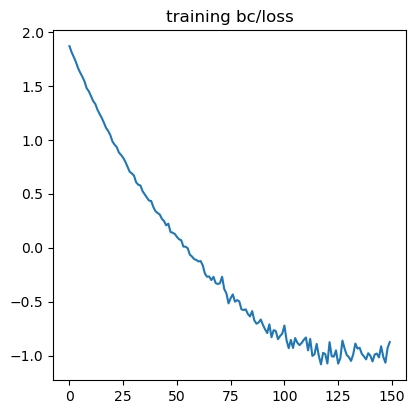

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

y_data = data[:, 5]
x_data = range(0, len(y_data)*2, 2)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(data[:, 1])
# plt.plot(x_data, y_data)
plt.title("training bc/loss")
plt.show()

# グラフを保存
plt.savefig('bc_loss.png')


In [15]:
import os

new_name = '24-02-08_e150_cnn_7_nono_S1'
# 新しいファイル名
new_csv_filename = './log/progress_' + new_name + '.csv'
new_txt_filename = './log/log_' + new_name + '.txt'

# 旧ファイル名から新ファイル名への変更
os.rename('./log/progress.csv', new_csv_filename)
os.rename('./log/log.txt', new_txt_filename)

# グラフを保存
plt.savefig('bc_loss_' + new_name + '.png')

from imitation.util import util
util.save_policy(bc_trainer.policy, './model/bc_policy_' + new_name)
bc_trainer.policy.save('./model/bc_policy' + new_name + '.zip')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>